In [ ]:
pip install transformers==4.37.2 peft==0.10.0

In [ ]:
# Install required packages
!pip install -q datasets torch scikit-learn matplotlib

In [ ]:
pip install optimum[onnxruntime]

In [ ]:
!pip install xgboost

In [ ]:
pip install accelerate==0.27.2

In [ ]:
pip uninstall onnxruntime

Found existing installation: onnxruntime 1.22.1
Uninstalling onnxruntime-1.22.1:
  Would remove:
    /usr/local/bin/onnxruntime_test
    /usr/local/lib/python3.11/dist-packages/onnxruntime-1.22.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/onnxruntime/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.11/dist-packages/onnxruntime/capi/libonnxruntime.so.1.22.0
    /usr/local/lib/python3.11/dist-packages/onnxruntime/capi/libonnxruntime_providers_cuda.so
    /usr/local/lib/python3.11/dist-packages/onnxruntime/capi/libonnxruntime_providers_tensorrt.so
Proceed (Y/n)? y
  Successfully uninstalled onnxruntime-1.22.1


In [ ]:
!pip install onnxruntime-gpu

In [ ]:
pip show onnxruntime-gpu

Name: onnxruntime-gpu
Version: 1.22.0
Summary: ONNX Runtime is a runtime accelerator for Machine Learning models
Home-page: https://onnxruntime.ai
Author: Microsoft Corporation
Author-email: onnxruntime@microsoft.com
License: MIT License
Location: /usr/local/lib/python3.11/dist-packages
Requires: coloredlogs, flatbuffers, numpy, packaging, protobuf, sympy
Required-by: 


In [ ]:
import onnxruntime as ort
print(ort.get_available_providers())

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [ ]:
# Load fine-tuned model and tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, set_seed
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
import onnxruntime as ort
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType
import os
import torch.quantization
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

ModuleNotFoundError: No module named 'onnxruntime'

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time
from torch.utils.data import DataLoader, TensorDataset

def evaluate_model(model, tokenizer, samples, labels, extract_features, name="Model", output_dir="./", batch_size=4, device="cuda"):
    device = torch.device(device)
    model.to(device)
    model.eval()

    # Preprocess input
    features = torch.tensor([extract_features(t) for t in samples], dtype=torch.float32)
    tokenized = tokenizer(samples, return_tensors="pt", padding=True, truncation=True, max_length=512)

    dataset = TensorDataset(
        tokenized["input_ids"],
        tokenized["attention_mask"],
        features,
        torch.tensor(labels)
    )

    loader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []
    all_labels = []

    start = time.time()
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, batch_features, batch_labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, features=batch_features)
            logits = outputs["logits"]
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    end = time.time()

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=False)
    cm = confusion_matrix(all_labels, all_preds)

    # Save classification report
    os.makedirs(output_dir, exist_ok=True)
    report_path = os.path.join(output_dir, f"{name.lower()}_classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Phishing"], yticklabels=["Legit", "Phishing"])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_confusion_matrix.png"))
    plt.close()

    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Inference Time: {end - start:.4f} sec")
    print(report)

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "inference_time": end - start
    }

In [ ]:
def evaluate_text_only_model(model, tokenizer, samples, labels, batch_size=32, device="cuda", name="Model", output_dir="./"):
    device = torch.device(device)
    model.to(device)
    model.eval()

    tokenized = tokenizer(samples, return_tensors="pt", padding=True, truncation=True, max_length=512)

    dataset = TensorDataset(
        tokenized["input_ids"],
        tokenized["attention_mask"],
        torch.tensor(labels)
    )

    loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, num_workers=2)

    all_preds = []
    all_labels = []

    import time
    start = time.time()
    with torch.inference_mode():
        for batch in loader:
            input_ids, attention_mask, batch_labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    end = time.time()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, f"{name.lower()}_classification_report.txt"), "w") as f:
        f.write(report)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit","Phishing"], yticklabels=["Legit","Phishing"])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_confusion_matrix.png"))
    plt.close()

    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Inference Time: {end - start:.2f} sec")
    print(report)

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "inference_time": end - start
    }


In [ ]:
def evaluate_classical_model(model, X, y_true, name="Model", output_dir=None):
    start = time.time()
    y_pred = model.predict(X)
    end = time.time()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    elapsed = end - start

    print(f"output_dir = {output_dir}")
    print(f"\n{name} Results:")
    print(f"  Accuracy:     {acc:.4f}")
    print(f"  F1 Score:     {f1:.4f}")
    print(f"  Inference Time (batch): {elapsed:.4f} sec")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{name} Confusion Matrix")
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f"{output_dir}/{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()

    report = classification_report(y_true, y_pred)
    print(report)

    if output_dir:
        with open(f"{output_dir}/{name.lower().replace(' ', '_')}_report.txt", "w") as f:
            f.write(report)

    return {"name": name, "accuracy": acc, "f1": f1, "inference_time": elapsed}

In [ ]:
# Dataset class
class EmailDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(list(df["cleaned text"]), truncation=True, padding="max_length", max_length=512)
        self.features = df[["link_count", "email length"]].values
        assert np.isfinite(self.features).all(), "Detected NaN or Inf in input features"
        self.labels = df["label"].values.astype(int)
        assert not np.isnan(self.labels).any(), "NaNs in labels"

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["features"] = torch.tensor(self.features[idx], dtype=torch.float32)
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
# Model class
class DebertaWithFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.deberta = AutoModel.from_pretrained("microsoft/deberta-v3-base")
        self.config = self.deberta.config
        self.config.return_dict = True
        self.hidden_size = self.deberta.config.hidden_size
        self.feature_proj = nn.Linear(2, 32)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, features=None, labels=None):
      deberta_output = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

      if self.config.return_dict:
          cls_output = deberta_output.last_hidden_state[:, 0]
      else:
          cls_output = deberta_output[0][:, 0]  # CLS token

      # Handle optional or empty features
      if features is not None and features.shape[1] > 0:
          feature_proj = self.feature_proj(features)
          feature_proj = torch.clamp(feature_proj, -10.0, 10.0)
          combined = torch.cat((cls_output, feature_proj), dim=1)
      else:
          combined = cls_output  # Only use CLS output when no features are passed

      logits = self.classifier(combined)

      # Debug for NaNs or infs
      if torch.isnan(logits).any() or torch.isinf(logits).any():
          print("NaNs in logits at batch")
          print("CLS shape:", cls_output.shape)
          print("Features:", features[0] if features is not None and features.shape[0] > 0 else "None")

      # Optional loss
      loss = None
      if labels is not None:
          loss_fn = nn.CrossEntropyLoss()
          loss = loss_fn(logits, labels)

      return {"loss": loss, "logits": logits, "labels": labels}

In [ ]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([torch.tensor(x["input_ids"]) for x in batch]),
        "attention_mask": torch.stack([torch.tensor(x["attention_mask"]) for x in batch])
    }

In [ ]:
# Extract structured features
def extract_features(email):
    return [email.count("http"), len(email)]

In [ ]:
def save_classification_report(report_str, filename):
    with open(filename, 'w') as f:
        f.write(report_str)
    print(f"Saved classification report to {filename}")

In [ ]:
class DebertaONNXWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask, features):
        out = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        return out["logits"]  # Return only tensor for ONNX export

In [ ]:
def evaluate_onnx_model(onnx_model_path, tokenizer, samples, labels, extract_features, name="ONNX", output_dir="./", batch_size=32):
    import time
    import os
    import numpy as np
    import onnxruntime as ort
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    from tqdm import tqdm

    # Precompute features for all samples
    all_features = np.array([extract_features(s) for s in samples], dtype=np.float32)

    # Initialize ONNX session with optimization
    sess_options = ort.SessionOptions()
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = ort.InferenceSession(onnx_model_path, sess_options)

    all_preds = []
    all_labels = []
    total_time = 0

    os.makedirs(output_dir, exist_ok=True)

    for i in tqdm(range(0, len(samples), batch_size), desc=f"Evaluating {name}"):
        batch_samples = samples[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        batch_features = all_features[i:i+batch_size]

        tokenized = tokenizer(batch_samples, return_tensors="np", padding="max_length", truncation=True, max_length=512)

        onnx_inputs = {
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"],
            "features": batch_features,
        }

        start = time.time()
        onnx_outputs = session.run(None, onnx_inputs)
        end = time.time()
        total_time += (end - start)

        logits = onnx_outputs[0]
        preds = np.argmax(logits, axis=-1)

        all_preds.extend(preds.tolist())
        all_labels.extend(batch_labels)

    # Metrics & report plotting
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    report_path = os.path.join(output_dir, f"{name.lower()}_classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Legit", "Phishing"], yticklabels=["Legit", "Phishing"])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_confusion_matrix.png"))
    plt.close()

    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Total Inference Time: {total_time:.4f} sec")
    print(report)

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "inference_time": total_time
    }


In [ ]:
def dummy_extract_features(text):
    return [0.0, 0.0]  # Matches expected input to self.feature_proj

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
output_dir = "/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison"
os.makedirs(output_dir, exist_ok=True)

model_path = "/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/New_Deberta_results/config_4/best_model_fold_5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = DebertaWithFeatures()
# Load the state dict
state_dict = torch.load(os.path.join(model_path, "model.pt"))

model.load_state_dict(state_dict)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

DebertaWithFeatures(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        

In [ ]:
import pandas as pd
data_path = '/content/drive/My Drive/Cybersecurity Practicum/'
df = pd.read_csv(os.path.join(data_path, "finalized_dataset.csv"))
df["cleaned text"] = df["cleaned text"].astype(str)
# Ensure label column is integer type
df["label"] = df["label"].astype(int)

#Fix extreme outliers
df["link_count"] = df["link_count"].clip(0, 100)
df["email length"] = df["email length"].clip(0, 20000)

NameError: name 'os' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["cleaned text", "link_count", "email length"]],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [ ]:
test_text = list(X_test["cleaned text"])
test_labels = list(y_test)

In [ ]:
train_text = list(X_train["cleaned text"])
train_labels = list(y_train)

In [ ]:
features_tensor = torch.tensor([extract_features(e) for e in train_text], dtype=torch.float32).to(device)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Tokenize
tokens = tokenizer(train_text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

# Unpack inputs
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

In [ ]:
import seaborn as sns
results = []

In [ ]:
results.append(evaluate_model(
    model=model,
    tokenizer=tokenizer,
    samples=test_text,
    labels=test_labels,
    extract_features=dummy_extract_features,
    name="Original",
    output_dir=output_dir,
    batch_size=64,
    device="cuda"
))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x768 and 800x128)

In [ ]:
export_model = DebertaONNXWrapper(model)
export_model.eval()
export_model.to(device)

DebertaONNXWrapper(
  (model): DebertaWithFeatures(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (Lay

In [ ]:
# Dummy input
dummy_text = "This is a sample input for ONNX export."
dummy_features = torch.tensor([[0.0, len(dummy_text)]], dtype=torch.float32)  # shape: [1, num_features]
inputs = tokenizer(dummy_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
dummy_features = dummy_features.to(device)

In [ ]:
from tqdm import tqdm
# ONNX Export
from transformers.onnx import export
from transformers.onnx.features import FeaturesManager
import onnxruntime as ort
import numpy as np

onnx_model_dir = "/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/GPU_ONNX_model"
os.makedirs(onnx_model_dir, exist_ok=True)
onnx_path = os.path.join(onnx_model_dir, "deberta_with_features.onnx")


torch.onnx.export(
    export_model,
    (input_ids, attention_mask, dummy_features),
    onnx_path,
    input_names=["input_ids", "attention_mask", "features"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "seq_len"},
        "attention_mask": {0: "batch_size", 1: "seq_len"},
        "features": {0: "batch_size"},
        "logits": {0: "batch_size"},
    },
    do_constant_folding=True,
    opset_version=13,
)

print(f"ONNX model exported to {onnx_path}")


'\n\ntorch.onnx.export(\n    export_model,\n    (input_ids, attention_mask, dummy_features),\n    onnx_path,\n    input_names=["input_ids", "attention_mask", "features"],\n    output_names=["logits"],\n    dynamic_axes={\n        "input_ids": {0: "batch_size", 1: "seq_len"},\n        "attention_mask": {0: "batch_size", 1: "seq_len"},\n        "features": {0: "batch_size"},\n        "logits": {0: "batch_size"},\n    },\n    do_constant_folding=True,\n    opset_version=13,\n)\n\nprint(f"ONNX model exported to {onnx_path}")\n'

In [ ]:
from onnxruntime.transformers.optimizer import optimize_model

# Optimize the model
optimized_model = optimize_model(onnx_path, model_type='bert')
# 'bert' optimization works well for transformer models like DeBERTa

optimized_model.save_model_to_file(os.path.join(onnx_model_dir, "deberta_with_features_optimized.onnx"))

In [ ]:
class DebertaCalibrationDataReader(CalibrationDataReader):
    def __init__(self, texts, features, tokenizer, max_length=128):
        self.data = []
        for text, feat in zip(texts, features):
            assert len(feat) == 2  # Expected shape (2,)
            enc = tokenizer(
                text,
                return_tensors="np",
                padding="max_length",
                truncation=True,
                max_length=max_length,
            )
            self.data.append({
                "input_ids": enc["input_ids"].astype(np.int64),  # shape (1, seq_len)
                "attention_mask": enc["attention_mask"].astype(np.int64),  # shape (1, seq_len)
                "features": np.array([feat], dtype=np.float32),  # shape (1, 2)
            })
        self.iterator = iter(self.data)

    def get_next(self):
        return next(self.iterator, None)


In [ ]:
# Calibration samples and features (from train set)
calib_texts = list(X_train["cleaned text"][:200])
calib_features = [extract_features(t) for t in calib_texts]

In [ ]:
reader = DebertaCalibrationDataReader(calib_texts, calib_features, tokenizer)

sample = reader.get_next()
print("Sample batch for calibration:")
for k, v in sample.items():
    print(f"{k}: shape={v.shape}, dtype={v.dtype}")


Sample batch for calibration:
input_ids: shape=(1, 128), dtype=int64
attention_mask: shape=(1, 128), dtype=int64
features: shape=(1, 2), dtype=float32


In [ ]:
calib_reader = DebertaCalibrationDataReader(calib_texts, calib_features, tokenizer)

In [ ]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantFormat, QuantType

In [ ]:
calib_reader.iterator = iter(calib_reader.data)  # reset before passing to quantize_static

In [ ]:
quantized_model_path = os.path.join(onnx_model_dir, "deberta_with_features_statically_quantized.onnx")
optimized_model_path = os.path.join(onnx_model_dir, "deberta_with_features_optimized.onnx")

quantize_static(
    model_input=optimized_model_path,
    model_output=quantized_model_path,
    calibration_data_reader=reader,
    quant_format=QuantFormat.QDQ,
    activation_type=QuantType.QUInt8,
    weight_type=QuantType.QInt8
)

print(f"✅ Static quantized model saved to {quantized_model_path}")

ValueError: No data is collected.

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_model_path = os.path.join(onnx_model_dir, "deberta_with_features_dynamically_quantized.onnx")
optimized_model_path = os.path.join(onnx_model_dir, "deberta_with_features_optimized.onnx")

quantize_dynamic(
    model_input=optimized_model_path,
    model_output=quantized_model_path,
    weight_type=QuantType.QInt8,
)

RuntimeError: Unable to find data type for weight_name='/model/deberta/encoder/layer.0/attention/self/key_proj/MatMul_output_0'. shape_inference failed to return a type probably this node is from a different domain or using an input produced by such an operator. This may happen if you quantize a model already quantized. You may use extra_options `DefaultTensorType` to indicate the default weight type, usually `onnx.TensorProto.FLOAT`.

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

unoptimized_quantized_model_path = os.path.join(onnx_model_dir, "unoptimized_deberta_with_features_dynamically_quantized.onnx")
'''
quantize_dynamic(
    model_input=onnx_path,
    model_output=unoptimized_quantized_model_path,
    weight_type=QuantType.QInt8,
    extra_options={"DefaultTensorType": "QInt8"},  # Or QuantType.QUInt8 depending on your needs
)
'''

'\nquantize_dynamic(\n    model_input=onnx_path,\n    model_output=unoptimized_quantized_model_path,\n    weight_type=QuantType.QInt8,\n    extra_options={"DefaultTensorType": "QInt8"},  # Or QuantType.QUInt8 depending on your needs\n)\n'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
def evaluate_onnx_model_fast(onnx_model_path, tokenizer, samples, labels, extract_features, name="ONNX", output_dir="./", batch_size=32):
    import time
    import os
    import numpy as np
    import onnxruntime as ort
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    from tqdm import tqdm

    # Use optimized ONNX inference session
    session = ort.InferenceSession(
        onnx_model_path,
        providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
    )

    # Precompute everything
    tokenized_all = tokenizer(samples, return_tensors="np", padding="max_length", truncation=True, max_length=512)
    all_features = np.array([extract_features(s) for s in samples], dtype=np.float32)

    # Setup ONNX session with optimized threading
    sess_options = ort.SessionOptions()
    sess_options.intra_op_num_threads = 2  # safe for Colab
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = ort.InferenceSession(onnx_model_path, sess_options, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

    all_preds = []
    all_labels = []
    total_time = 0

    os.makedirs(output_dir, exist_ok=True)

    for i in tqdm(range(0, len(samples), batch_size), desc=f"Evaluating {name}"):
        input_ids = tokenized_all["input_ids"][i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        attention_mask = tokenized_all["attention_mask"][i:i+batch_size]
        features = all_features[i:i+batch_size]

        onnx_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "features": features,
        }

        # Inference timing
        start = time.time()
        logits = session.run(None, onnx_inputs)[0]
        end = time.time()
        total_time += (end - start)

        preds = np.atleast_1d(np.argmax(logits, axis=-1))

        all_preds.extend(preds.tolist())
        all_labels.extend(batch_labels)

    # Metrics & report plotting
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    report_path = os.path.join(output_dir, f"{name.lower()}_classification_report.txt")
    with open(report_path, "w") as f:
        f.write(report)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Legit", "Phishing"], yticklabels=["Legit", "Phishing"])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_confusion_matrix.png"))
    plt.close()

    print(f"\n {name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Total Inference Time: {total_time:.4f} sec")
    print(report)

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "inference_time": total_time
    }


In [ ]:
results.append(
    evaluate_onnx_model_fast(
        onnx_model_path=optimized_model_path,
        tokenizer=tokenizer,
        samples=test_text,
        labels=test_labels,
        extract_features=dummy_extract_features,
        name="Optimized ONNX",
        output_dir=onnx_model_dir,
        batch_size=64
    )
)

Evaluating Optimized ONNX: 100%|██████████| 275/275 [01:32<00:00,  2.97it/s]



✅ Optimized ONNX Evaluation:
Accuracy: 0.9981
F1 Score: 0.9982
Total Inference Time: 92.4625 sec
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7915
           1       1.00      1.00      1.00      9644

    accuracy                           1.00     17559
   macro avg       1.00      1.00      1.00     17559
weighted avg       1.00      1.00      1.00     17559



In [ ]:
results.append(
    evaluate_onnx_model_fast(
        onnx_model_path=unoptimized_quantized_model_path,
        tokenizer=tokenizer,
        samples=test_text,
        labels=test_labels,
        extract_features=dummy_extract_features,
        name="Unoptimized Quantized ONNX",
        output_dir=onnx_model_dir,
        batch_size=64
    )
)

Evaluating Unoptimized Quantized ONNX: 100%|██████████| 275/275 [55:04<00:00, 12.02s/it]



✅ Unoptimized Quantized ONNX Evaluation:
Accuracy: 0.5431
F1 Score: 0.6814
Total Inference Time: 3304.7519 sec
              precision    recall  f1-score   support

           0       0.47      0.12      0.19      7915
           1       0.55      0.89      0.68      9644

    accuracy                           0.54     17559
   macro avg       0.51      0.51      0.44     17559
weighted avg       0.52      0.54      0.46     17559



In [ ]:
import onnx
from onnx import TensorProto

fixed_model_path = os.path.join(onnx_model_dir, "fixed_optimized_deberta_with_features_quantized.onnx")

model_path = quantized_model_path
model = onnx.load(model_path)

for node in model.graph.node:
    if node.op_type == "Cast":
        for attr in node.attribute:
            if attr.name == "to" and attr.type == onnx.AttributeProto.STRING:
                dtype_str = attr.s.decode("utf-8")  # e.g. "QInt8"
                # Map 'QInt8' to 'INT8'
                if dtype_str == "QInt8":
                    dtype_str = "INT8"
                mapping = {
                    "FLOAT": TensorProto.FLOAT,
                    "UINT8": TensorProto.UINT8,
                    "INT8": TensorProto.INT8,
                    "UINT16": TensorProto.UINT16,
                    "INT16": TensorProto.INT16,
                    "INT32": TensorProto.INT32,
                    "INT64": TensorProto.INT64,
                    "STRING": TensorProto.STRING,
                    "BOOL": TensorProto.BOOL,
                    # add more if needed
                }
                if dtype_str in mapping:
                    attr.type = onnx.AttributeProto.INT
                    attr.i = mapping[dtype_str]
                    attr.ClearField("s")
                else:
                    print(f"Unknown Cast type: {dtype_str}")

onnx.save(model, fixed_model_path)


In [ ]:
# TF-IDF for text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_text = vectorizer.fit_transform(X_train["cleaned text"])
X_test_text = vectorizer.transform(X_test["cleaned text"])

In [ ]:
# Scale numeric features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_num = scaler.fit_transform(X_train[["link_count", "email length"]])
X_test_num = scaler.transform(X_test[["link_count", "email length"]])

In [ ]:
# Combine
X_train_combined = hstack([X_train_text, X_train_num])
X_test_combined = hstack([X_test_text, X_test_num])

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_combined, y_train)

MultinomialNB()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_combined, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
comparison_dir = "/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Comparison_results"
os.makedirs(comparison_dir, exist_ok=True)

output_dir = /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Comparison_results

Naive Bayes Results:
  Accuracy:     0.9551
  F1 Score:     0.9592
  Inference Time (batch): 0.0171 sec


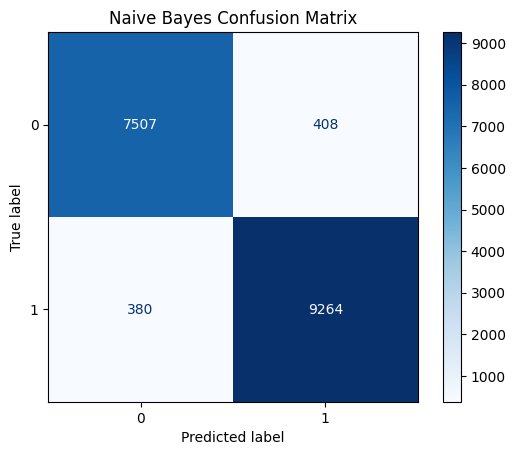

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7915
           1       0.96      0.96      0.96      9644

    accuracy                           0.96     17559
   macro avg       0.95      0.95      0.95     17559
weighted avg       0.96      0.96      0.96     17559

output_dir = /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Comparison_results

Logistic Regression Results:
  Accuracy:     0.9826
  F1 Score:     0.9842
  Inference Time (batch): 0.0126 sec


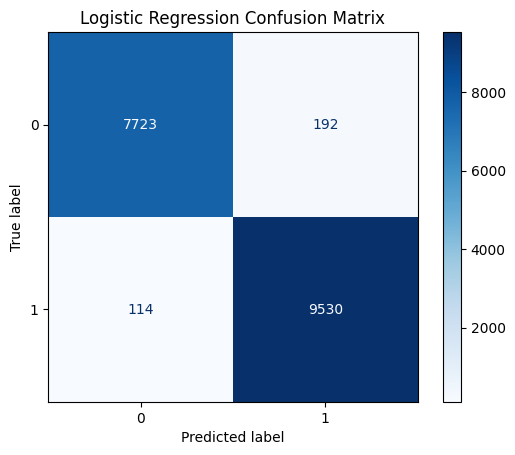

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7915
           1       0.98      0.99      0.98      9644

    accuracy                           0.98     17559
   macro avg       0.98      0.98      0.98     17559
weighted avg       0.98      0.98      0.98     17559



In [ ]:
results = []
results.append(evaluate_classical_model(nb_model, X_test_combined, y_test, name="Naive Bayes", output_dir=comparison_dir))
results.append(evaluate_classical_model(lr_model, X_test_combined, y_test, name="Logistic Regression", output_dir=comparison_dir))

In [ ]:
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV

X_sample, y_sample = resample(X_train_combined, y_train, n_samples=2000, random_state=42)
base_svm = SVC()  # probability=False by default
svm_model = CalibratedClassifierCV(base_svm, cv=3)
svm_model.fit(X_sample, y_sample)

CalibratedClassifierCV(cv=3, estimator=SVC())

output_dir = /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Comparison_results

SVM Results:
  Accuracy:     0.9648
  F1 Score:     0.9682
  Inference Time (batch): 29.6462 sec


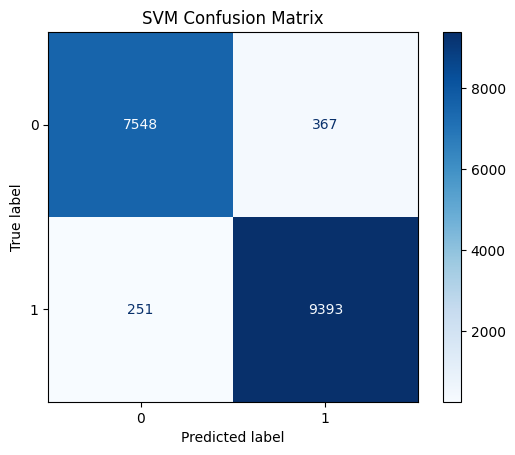

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7915
           1       0.96      0.97      0.97      9644

    accuracy                           0.96     17559
   macro avg       0.97      0.96      0.96     17559
weighted avg       0.96      0.96      0.96     17559



In [ ]:
results += [
    evaluate_classical_model(svm_model, X_test_combined, y_test, name="SVM", output_dir=comparison_dir),
]

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_sample, y_sample)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,
                       random_state=42)

output_dir = /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Comparison_results

Random Forest Results:
  Accuracy:     0.8737
  F1 Score:     0.8933
  Inference Time (batch): 0.0543 sec


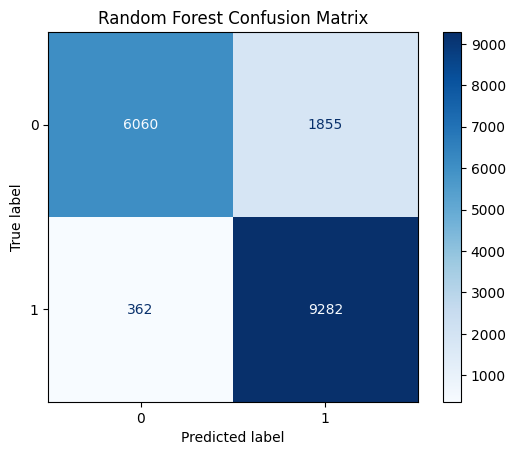

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      7915
           1       0.83      0.96      0.89      9644

    accuracy                           0.87     17559
   macro avg       0.89      0.86      0.87     17559
weighted avg       0.88      0.87      0.87     17559



In [ ]:
results += [
    evaluate_classical_model(rf_model, X_test_combined, y_test, name="Random Forest", output_dir=comparison_dir),
]

In [ ]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1
)

xgb_model.fit(X_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

output_dir = /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Comparison_results

XGBoost Results:
  Accuracy:     0.9294
  F1 Score:     0.9372
  Inference Time (batch): 0.0287 sec


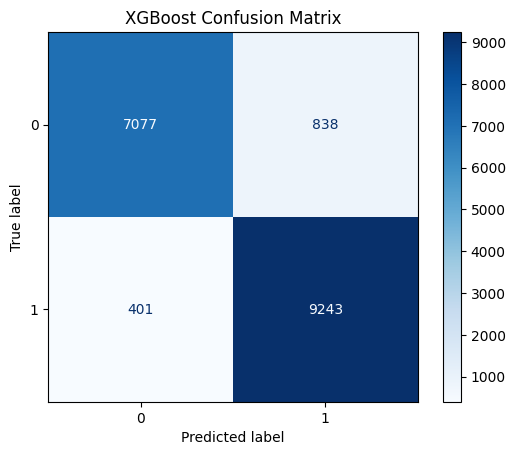

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7915
           1       0.92      0.96      0.94      9644

    accuracy                           0.93     17559
   macro avg       0.93      0.93      0.93     17559
weighted avg       0.93      0.93      0.93     17559



In [ ]:
results += [
    evaluate_classical_model(xgb_model, X_test_combined, y_test, name="XGBoost", output_dir=comparison_dir)
]

In [ ]:
# Imports
from transformers import (
    Trainer, TrainingArguments
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Extract text only
train_texts = list(X_train["cleaned text"])
train_labels = list(y_train)  # or y_train.tolist()

test_texts = list(X_test["cleaned text"])
test_labels = list(y_test)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

set_seed(42)

bert_model_name = "bert-base-uncased"
distilbert_model_name = "distilbert-base-uncased"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=2).to("cuda")

distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name, num_labels=2).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
def save_classification_report(report_str, filename):
    with open(filename, 'w') as f:
        f.write(report_str)
    print(f"Saved classification report to {filename}")

In [ ]:
import os
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset

def run_k_fold_training(model_name, encodings, labels, k=5, output_dir="bert_kfold_results"):
    os.makedirs(output_dir, exist_ok=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(encodings["input_ids"], labels), 1):
        fold_model_dir = os.path.join(output_dir, f"model_fold_{fold}")
        report_path = os.path.join(fold_model_dir, "classification_report.txt")

        # Skip completed folds
        if os.path.exists(report_path):
            print(f"Fold {fold} already completed — skipping.")
            continue

        print(f"\nStarting Fold {fold}/{k}")
        os.makedirs(fold_model_dir, exist_ok=True)

        # Prepare fold data
        train_dataset = Dataset.from_dict({
            "input_ids": [encodings["input_ids"][i] for i in train_idx],
            "attention_mask": [encodings["attention_mask"][i] for i in train_idx],
            "labels": [labels[i] for i in train_idx],
        })

        val_dataset = Dataset.from_dict({
            "input_ids": [encodings["input_ids"][i] for i in val_idx],
            "attention_mask": [encodings["attention_mask"][i] for i in val_idx],
            "labels": [labels[i] for i in val_idx],
        })

        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

        training_args = TrainingArguments(
            output_dir=os.path.join(output_dir, f"fold_{fold}"),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=1e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            logging_dir=os.path.join(output_dir, f"logs/fold_{fold}"),
            logging_steps=10,
            save_total_limit=1,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        )

        trainer.train()

        # Evaluate
        eval_result = trainer.evaluate()
        all_metrics.append(eval_result)
        print(f"Fold {fold} results:", eval_result)

        # Predictions
        predictions = trainer.predict(val_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids

        # Save confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Fold {fold}")
        cm_path = os.path.join(output_dir, f"confusion_matrix_fold_{fold}.png")
        plt.savefig(cm_path)
        plt.close()
        print(f"Confusion matrix saved to {cm_path}")

        # Save model and tokenizer
        trainer.save_model(fold_model_dir)
        tokenizer.save_pretrained(fold_model_dir)
        print(f"Model and tokenizer saved to {fold_model_dir}")

        # Save predictions and true labels
        np.save(os.path.join(fold_model_dir, "val_preds.npy"), y_pred)
        np.save(os.path.join(fold_model_dir, "val_labels.npy"), y_true)

        # Save classification report
        val_class_report = classification_report(
            y_true, y_pred, target_names=["Legit", "Phish"], digits=4
        )
        with open(report_path, "w") as f:
            f.write(val_class_report)
        print(f"Classification report saved to {report_path}")

        # Confirm what was saved
        print(f"Fold {fold} saved files:", os.listdir(fold_model_dir))

    # Average metrics only over completed folds
    if all_metrics:
        avg_metrics = {metric: np.mean([m[metric] for m in all_metrics]) for metric in all_metrics[0]}
        std_metrics = {metric: np.std([m[metric] for m in all_metrics]) for metric in all_metrics[0]}

        print("\nAverage Results Across Completed Folds:")
        for k in avg_metrics:
            print(f"{k}: {avg_metrics[k]:.4f} ± {std_metrics[k]:.4f}")
    else:
        avg_metrics = std_metrics = {}
        print("No folds were trained in this run.")

    return all_metrics, avg_metrics, std_metrics


In [ ]:
# Tokenize
encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=512)

In [ ]:
from scipy.special import softmax
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.special import softmax
import numpy as np

In [ ]:
def compute_metrics(eval_pred):
    # eval_pred is now a `EvalPrediction` object with .predictions and .label_ids
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    # Sanitize logits
    logits = np.array(logits, dtype=np.float32)
    if not np.isfinite(logits).all():
        print("Detected NaN or Inf in logits before softmax")
        logits = np.nan_to_num(logits, nan=0.0, posinf=10.0, neginf=-10.0)

    predictions = np.argmax(logits, axis=-1)

    # Convert logits to probabilities using softmax
    if logits.shape[1] == 2:
      probs = softmax(logits, axis=1)[:, 1]  # Probability for class 1
    else:
      raise ValueError(f"Unexpected logits shape: {logits.shape}. Expected 2 classes for binary classification.")

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, predictions)

    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float('nan')

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
    }

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Run
metrics, avg, std = run_k_fold_training(bert_model_name, encodings, train_labels, k=5, output_dir=os.path.join(output_dir, "new_bert_kfold_results"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


⏭️ Fold 1 already completed — skipping.
⏭️ Fold 2 already completed — skipping.

🔁 Starting Fold 3/5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jessica-borowy-1 (jessica-borowy-1-georgia-tech-yellow-jackets) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.058300,0.041173,0.989037,0.989953,0.996585,0.983409,0.999624
2,0.000200,0.024182,0.995373,0.995791,0.994953,0.996630,0.999579
3,0.000300,0.028066,0.994803,0.995261,0.997008,0.993519,0.999759


✅ Fold 3 results: {'eval_loss': 0.024181749671697617, 'eval_accuracy': 0.9953726774400228, 'eval_f1': 0.9957909732564916, 'eval_precision': 0.9949534161490683, 'eval_recall': 0.9966299416720674, 'eval_roc_auc': 0.9995792237599019, 'eval_runtime': 109.7307, 'eval_samples_per_second': 128.013, 'eval_steps_per_second': 8.001, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/confusion_matrix_fold_3.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_3
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_3/classification_report.txt
📁 Fold 3 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_map.j

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.056000,0.043328,0.991385,0.992126,0.996210,0.988075,0.999673
2,0.000200,0.024953,0.994376,0.994874,0.995973,0.993778,0.999821
3,0.000000,0.031154,0.994020,0.994541,0.997263,0.991834,0.999856


✅ Fold 4 results: {'eval_loss': 0.024953216314315796, 'eval_accuracy': 0.994375622953154, 'eval_f1': 0.9948744566275223, 'eval_precision': 0.9959729799948038, 'eval_recall': 0.9937783538561245, 'eval_roc_auc': 0.999820795593451, 'eval_runtime': 109.9385, 'eval_samples_per_second': 127.762, 'eval_steps_per_second': 7.986, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/confusion_matrix_fold_4.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_4
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_4/classification_report.txt
📁 Fold 4 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_map.jso

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.004000,0.043537,0.990602,0.991413,0.995168,0.987686,0.999393
2,0.028900,0.031668,0.993664,0.994243,0.992381,0.996111,0.999714
3,0.000000,0.034210,0.994945,0.995391,0.997009,0.993778,0.999741


✅ Fold 5 results: {'eval_loss': 0.03420967236161232, 'eval_accuracy': 0.9949451801224548, 'eval_f1': 0.9953911067835118, 'eval_precision': 0.9970091027308192, 'eval_recall': 0.9937783538561245, 'eval_roc_auc': 0.9997413994220131, 'eval_runtime': 110.8673, 'eval_samples_per_second': 126.692, 'eval_steps_per_second': 7.919, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/confusion_matrix_fold_5.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_5
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_5/classification_report.txt
📁 Fold 5 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_map.js

In [ ]:
print("Training finished. Verifying model fold outputs:")
!ls -lhR "/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/"

✅ Training finished. Verifying model fold outputs:
'/content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/':
total 155K
-rw------- 1 root root  23K Jul  6 20:15 confusion_matrix_fold_1.png
-rw------- 1 root root  24K Jul  6 21:29 confusion_matrix_fold_2.png
-rw------- 1 root root  22K Jul  7 00:10 confusion_matrix_fold_3.png
-rw------- 1 root root  21K Jul  7 01:24 confusion_matrix_fold_4.png
-rw------- 1 root root  22K Jul  7 02:38 confusion_matrix_fold_5.png
drwx------ 2 root root 4.0K Jul  6 19:01 fold_1
drwx------ 2 root root 4.0K Jul  6 20:15 fold_2
drwx------ 3 root root 4.0K Jul  7 00:06 fold_3
drwx------ 3 root root 4.0K Jul  7 01:20 fold_4
drwx------ 3 root root 4.0K Jul  7 02:34 fold_5
drwx------ 5 root root 4.0K Jul  7 01:24 logs
drwx------ 2 root root 4.0K Jul  6 19:01 model_fold_1
drwx------ 2 root root 4.0K Jul  6 20:15 model_fold_2
drwx------ 2 root root 4.0K Jul  7 00:10 model_fold_3
drwx------ 2 root ro

In [ ]:
best_model_dir = os.path.join(output_dir, 'new_bert_kfold_results', f"model_fold_3") #TODO Change this to the actual best one
bert_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
print(f"Best model loaded from {best_model_dir}")

✅ Best model loaded from /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/new_bert_kfold_results/model_fold_3


In [ ]:
results = []
import seaborn as sns

In [ ]:
# BERT text-only
results.append(evaluate_text_only_model(
    model=bert_model,
    tokenizer=bert_tokenizer,
    samples=test_texts,
    labels=test_labels,
    batch_size=32,
    device="cuda",
    name="BERT",
    output_dir=output_dir
))


✅ BERT Evaluation:
Accuracy: 0.9945
F1 Score: 0.9950
Inference Time: 118.65 sec
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7915
           1       0.99      1.00      0.99      9644

    accuracy                           0.99     17559
   macro avg       0.99      0.99      0.99     17559
weighted avg       0.99      0.99      0.99     17559



In [ ]:
# Tokenize
encodings = distilbert_tokenizer(train_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# Run
metrics, avg, std = run_k_fold_training(distilbert_model_name, encodings, train_labels, k=5, output_dir=os.path.join(output_dir, "distilbert_kfold_results"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


⏭️ Fold 1 already completed — skipping.

🔁 Starting Fold 2/5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.048800,0.031955,0.991742,0.992471,0.993891,0.991056,0.999649
2,0.000400,0.034134,0.993166,0.993799,0.990473,0.997148,0.999685
3,0.000000,0.027915,0.995373,0.995784,0.996624,0.994945,0.999763


✅ Fold 2 results: {'eval_loss': 0.02791486121714115, 'eval_accuracy': 0.9953726774400228, 'eval_f1': 0.9957838749432445, 'eval_precision': 0.9966242534406647, 'eval_recall': 0.9949449125081011, 'eval_roc_auc': 0.9997630568471146, 'eval_runtime': 61.023, 'eval_samples_per_second': 230.192, 'eval_steps_per_second': 14.388, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/confusion_matrix_fold_2.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_2
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_2/classification_report.txt
📁 Fold 2 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_m

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.052900,0.029802,0.993095,0.993712,0.993906,0.993519,0.999486
2,0.000200,0.028857,0.994803,0.995279,0.993160,0.997408,0.999734
3,0.000100,0.029199,0.994661,0.995137,0.995589,0.994686,0.999747


✅ Fold 3 results: {'eval_loss': 0.02885713241994381, 'eval_accuracy': 0.9948031608172564, 'eval_f1': 0.9952790532238246, 'eval_precision': 0.9931595250387196, 'eval_recall': 0.9974076474400518, 'eval_roc_auc': 0.9997342961447558, 'eval_runtime': 60.7043, 'eval_samples_per_second': 231.4, 'eval_steps_per_second': 14.464, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/confusion_matrix_fold_3.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_3
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_3/classification_report.txt
📁 Fold 3 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_ma

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.066200,0.037664,0.991314,0.992077,0.994143,0.990019,0.999493
2,0.000100,0.031448,0.993664,0.994210,0.998041,0.990408,0.999762
3,0.017600,0.028474,0.995088,0.995521,0.997139,0.993908,0.999832


✅ Fold 4 results: {'eval_loss': 0.02847420610487461, 'eval_accuracy': 0.99508756941478, 'eval_f1': 0.9955209347614411, 'eval_precision': 0.9971391417425227, 'eval_recall': 0.9939079714841218, 'eval_roc_auc': 0.9998323016915295, 'eval_runtime': 61.1721, 'eval_samples_per_second': 229.614, 'eval_steps_per_second': 14.353, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/confusion_matrix_fold_4.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_4
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_4/classification_report.txt
📁 Fold 4 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens_ma

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.001100,0.049675,0.987185,0.988249,0.995528,0.981076,0.999346
2,0.035400,0.039750,0.992667,0.993305,0.996219,0.990408,0.999590
3,0.000100,0.040097,0.992881,0.993503,0.995962,0.991056,0.999666


✅ Fold 5 results: {'eval_loss': 0.040097106248140335, 'eval_accuracy': 0.9928805353837391, 'eval_f1': 0.9935031185031185, 'eval_precision': 0.9959619643089749, 'eval_recall': 0.9910563836681788, 'eval_roc_auc': 0.9996655758735551, 'eval_runtime': 60.8847, 'eval_samples_per_second': 230.698, 'eval_steps_per_second': 14.421, 'epoch': 3.0}
🧩 Confusion matrix saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/confusion_matrix_fold_5.png
✅ Model and tokenizer saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_5
📄 Classification report saved to /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_5/classification_report.txt
📁 Fold 5 saved files: ['config.json', 'model.safetensors', 'training_args.bin', 'tokenizer_config.json', 'special_tokens

In [ ]:
best_model_dir = os.path.join(output_dir, 'distilbert_kfold_results', f"model_fold_2") #Set this to the best one after reviewing the metrics
distilbert_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
print(f"Best model loaded from {best_model_dir}")

✅ Best model loaded from /content/drive/My Drive/Cybersecurity Practicum/Custom_CV_phishing_results/Performance_Comparison/distilbert_kfold_results/model_fold_2


In [ ]:
# DistilBERT text-only
results.append(evaluate_text_only_model(
    model=distilbert_model,
    tokenizer=distilbert_tokenizer,
    samples=test_texts,
    labels=test_labels,
    batch_size=32,
    device="cuda",
    name="DistilBERT",
    output_dir=output_dir
))


✅ DistilBERT Evaluation:
Accuracy: 0.9949
F1 Score: 0.9954
Inference Time: 60.78 sec
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7915
           1       1.00      0.99      1.00      9644

    accuracy                           0.99     17559
   macro avg       0.99      1.00      0.99     17559
weighted avg       0.99      0.99      0.99     17559



In [ ]:
import pandas as pd
df_results = pd.DataFrame(results)
df_results.sort_values(by="f1", ascending=False, inplace=True)
display(df_results)

,name,accuracy,f1,inference_time
0,Original,0.998064,0.998236,200.237151
8,Optimized ONNX,0.998064,0.998236,92.462500
6,DistilBERT,0.994900,0.995400,60.780000
7,BERT,0.994500,0.995000,118.650000
1,Logistic Regression,0.982573,0.984199,0.012605
2,SVM,0.964804,0.968151,29.646197
3,Naive Bayes,0.955123,0.959205,0.017122
4,XGBoost,0.929438,0.937186,0.028687
5,Random Forest,0.873740,0.893316,0.054263


In [ ]:
df_results.to_csv(os.path.join(comparison_dir, "model_comparison.csv"), index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

In [ ]:
def plot_model_scores(df_results):
    melted = df_results.melt(
        id_vars="name",
        value_vars=["accuracy", "f1"],
        var_name="Metric",
        value_name="Score"
    )

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="name", y="Score", hue="Metric", data=melted)
    plt.title("Model Accuracy & F1 Score Comparison")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.05)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(comparison_dir, "model_scores.png"))

In [ ]:
def plot_inference_times(df_results):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x="name", y="inference_time", data=df_results, palette="crest")
    plt.title("Model Inference Time (Batch)")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha="right")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f", label_type="edge", padding=2)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(comparison_dir, "inference_times.png"))

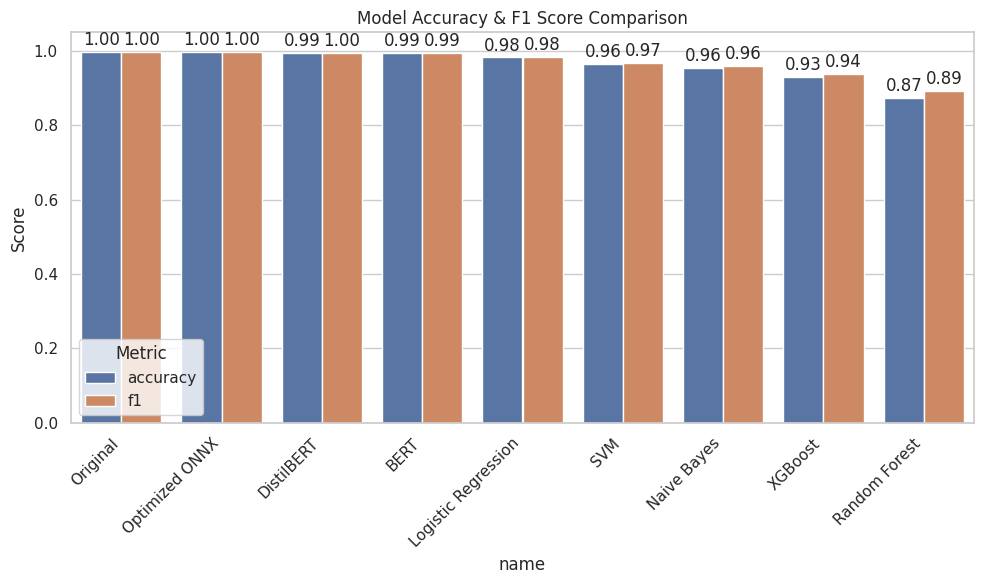

/tmp/ipython-input-11-1368839289.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="name", y="inference_time", data=df_results, palette="crest")


<Figure size 640x480 with 0 Axes>

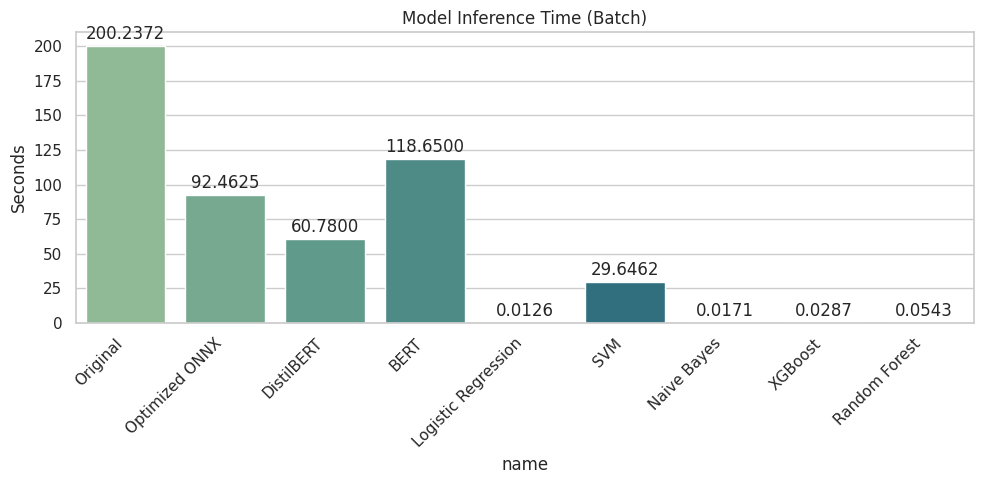

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_model_scores(df_results)
plot_inference_times(df_results)